# Initialize

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch import nn
import matplotlib.pyplot as plt


from AE.models import AE_0
from AE.train import train
from AE.datasets import MNISTDigit2Dataset
from AE.utils import get_binary_latent_frequencies, analyze_binary_frequencies
from AE.plotter_functions import plot_original_vs_decoded

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Utilizzo Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilizzo NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Utilizzo la CPU")

device = torch.device("cpu")  # Fallback to CPU if no GPU is available

SEED = 42
torch.manual_seed(SEED)

Utilizzo Apple Silicon GPU (MPS)


# Datasets


In [5]:
batch_size = 64

## MNIST


In [6]:

train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



## ExtendedMNIST


In [7]:

train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



## 2MNIST


In [8]:

dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=batch_size, shuffle=True)

batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=batch_size, shuffle=True)

print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")


Found 5958 original samples of digit '2'
Generated 60000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True

––––––––––––––––––––––––––––––––––––––––––––––––––––––

Found 1032 original samples of digit '2'
Generated 10000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
All labels are 2: True
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True



## FashionMNIST


In [ ]:

train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



## OTHERS


In [ ]:
## train over pureHFM

dataset_HFM_train = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_pureHFM = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_pureHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)
## train over expandedHFM
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)
## train over expandedHFM 32-1024
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)


# Autoencoders model 0


In [15]:
learning_rate = 1e-3
weight_decay = 1e-5



## EMNIST


In [18]:
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 784



### 8 features


In [ ]:
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_1hl.pth', map_location=my_model.device))


In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_ep15_dr05_1hl')
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_1hl.pth')


In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_ep15_dr05_1hl_1')
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=1).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_1hl_1.pth')



# controlliamo

In [14]:
from torch.optim.lr_scheduler import StepLR

In [51]:
from torch.optim.lr_scheduler import ExponentialLR

# MNIST

In [84]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784

In [85]:
learning_rate = 1e-3
weight_decay = 1e-5

## 8 features

In [ ]:
# 1 hidden layer
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_1hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_1hl.pth')

# 2 hidden layers
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_2hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_2hl.pth')

# 3 hidden layers
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_3hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_3hl.pth')

# 4 hidden layers
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_4hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_4hl.pth')


Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0004
Epoch: 2/15, Average loss: 0.0004
Epoch: 3/15, Average loss: 0.0004
Epoch: 4/15, Average loss: 0.0004
Epoch: 5/15, Average loss: 0.0004
Epoch: 6/15, Average loss: 0.0004
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch: 11/15, Average loss: 0.0004
Epoch: 12/15, Average loss: 0.0004
Epoch: 13/15, Average loss: 0.0004
Epoch: 14/15, Average loss: 0.0004
Training completed. Final training loss: 0.00039343795993675786, Validation loss: 0.0003899347236379981
Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0004
Epoch: 2/15, Average loss: 0.0004
Epoch: 3/15, Average loss: 0.0004
Epoch: 4/15, Average loss: 0.0004
Epoch: 5/15, Average loss: 0.0004
Epoch: 6/15, Average loss: 0.0004
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch:

KeyboardInterrupt: 

In [ ]:
# 5 hidden layers
learning_rate = 1e-4

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.55, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_ep15_dr055_lr1e4_opeSigm_5hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr055_lr1e4_opeSigm_5hl.pth')


Epoch: 0/15, Average loss: 0.0010
Epoch: 1/15, Average loss: 0.0009
Epoch: 2/15, Average loss: 0.0008
Epoch: 3/15, Average loss: 0.0008
Epoch: 4/15, Average loss: 0.0008
Epoch: 5/15, Average loss: 0.0007
Epoch: 6/15, Average loss: 0.0007
Epoch: 7/15, Average loss: 0.0007
Epoch: 8/15, Average loss: 0.0007
Epoch: 9/15, Average loss: 0.0007
Epoch: 10/15, Average loss: 0.0007
Epoch: 11/15, Average loss: 0.0007
Epoch: 12/15, Average loss: 0.0007
Epoch: 13/15, Average loss: 0.0007
Epoch: 14/15, Average loss: 0.0007
Training completed. Final training loss: 0.0006705451377977927, Validation loss: 0.0006723556384444237
Epoch: 0/15, Average loss: 0.0011
Epoch: 1/15, Average loss: 0.0011
Epoch: 2/15, Average loss: 0.0011
Epoch: 3/15, Average loss: 0.0011
Epoch: 4/15, Average loss: 0.0011
Epoch: 5/15, Average loss: 0.0011
Epoch: 6/15, Average loss: 0.0011
Epoch: 7/15, Average loss: 0.0011
Epoch: 8/15, Average loss: 0.0011
Epoch: 9/15, Average loss: 0.0011
Epoch: 10/15, Average loss: 0.0011
Epoch: 

In [ ]:
# 6 hidden layers
learning_rate = 1e-5
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_ep15_dr06_lr1e5_opeSigm_6hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr06_lr1e5_opeSigm_6hl.pth')


Epoch: 0/15, Average loss: 0.0013
Epoch: 1/15, Average loss: 0.0010
Epoch: 2/15, Average loss: 0.0010
Epoch: 3/15, Average loss: 0.0010
Epoch: 4/15, Average loss: 0.0010
Epoch: 5/15, Average loss: 0.0010
Epoch: 6/15, Average loss: 0.0009
Epoch: 7/15, Average loss: 0.0009
Epoch: 8/15, Average loss: 0.0009
Epoch: 9/15, Average loss: 0.0009
Epoch: 10/15, Average loss: 0.0009
Epoch: 11/15, Average loss: 0.0009
Epoch: 12/15, Average loss: 0.0009
Epoch: 13/15, Average loss: 0.0008
Epoch: 14/15, Average loss: 0.0008
Training completed. Final training loss: 0.0008423349551856517, Validation loss: 0.00084237618483603


In [104]:

# 7 hidden layers

learning_rate = 1e-5

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_ep15_dr06_lr1e5_slr5_01_opeSigm_7hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15, scheduler=scheduler)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr06_lr1e5_slr5_01_opeSigm_7hl.pth')

Epoch: 0/15, Average loss: 0.0013
Epoch: 1/15, Average loss: 0.0011
Epoch: 2/15, Average loss: 0.0011
Epoch: 3/15, Average loss: 0.0011
Epoch: 4/15, Average loss: 0.0011
Epoch: 5/15, Average loss: 0.0011
Epoch: 6/15, Average loss: 0.0011
Epoch: 7/15, Average loss: 0.0011
Epoch: 8/15, Average loss: 0.0011
Epoch: 9/15, Average loss: 0.0011
Epoch: 10/15, Average loss: 0.0011
Epoch: 11/15, Average loss: 0.0011
Epoch: 12/15, Average loss: 0.0011
Epoch: 13/15, Average loss: 0.0011
Epoch: 14/15, Average loss: 0.0011
Training completed. Final training loss: 0.001051405894694229, Validation loss: 0.001059711416810751


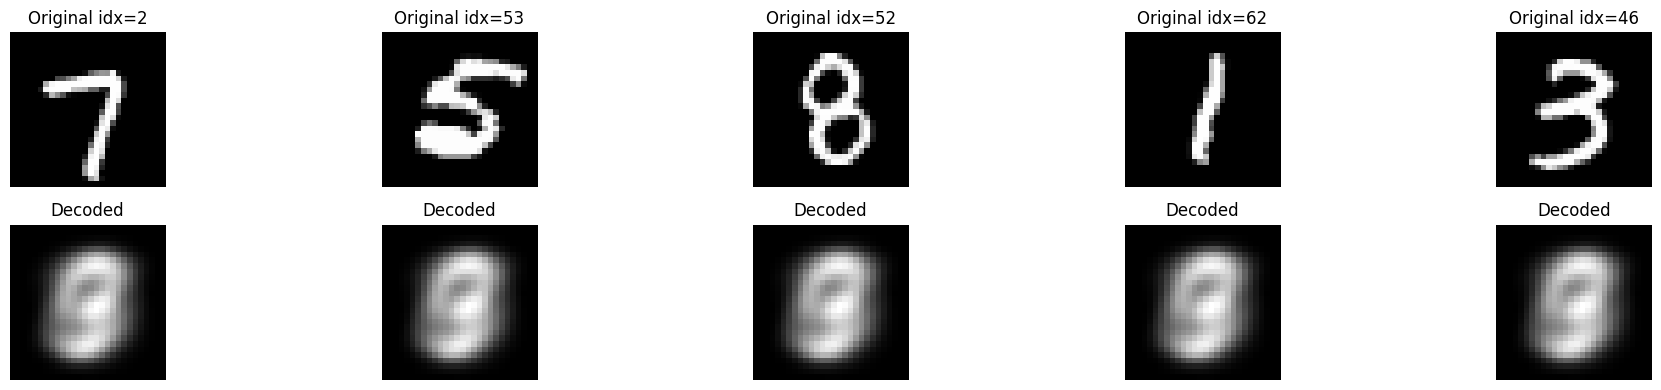

In [109]:
plot_original_vs_decoded(my_model, train_loader, device=device, num_samples=5)